In [ ]:
!pip install -qU langchain-teddynote

In [1]:
from typing import TypedDict


# GraphState 상태를 저장하는 용도로 사용합니다.
class GraphState(TypedDict):
    filepath: str  # path
    filetype: str  # pdf
    page_numbers: list[int]  # page numbers
    batch_size: int  # batch size
    split_filepaths: list[str]  # split files
    analyzed_files: list[str]  # analyzed files
    page_elements: dict[int, dict[str, list[dict]]]  # page elements
    page_metadata: dict[int, dict]  # page metadata
    page_summary: dict[int, str]  # page summary
    images: list[str]  # image paths
    images_base64: list[str] #base64 image
    images_summary: list[str]  # image summary
    tables: list[str]  # table
    tables_summary: dict[int, str]  # table summary
    texts: list[str]  # text
    texts_summary: list[str]  # text summary

In [85]:
import os
import pymupdf
import json
import requests
from PIL import Image
import dotenv
import base64
import io
dotenv.load_dotenv()

True

In [3]:
def split_pdf(state: GraphState):
    """
    입력 PDF를 여러 개의 작은 PDF 파일로 분할합니다.

    :param state: GraphState 객체, PDF 파일 경로와 배치 크기 정보를 포함
    :return: 분할된 PDF 파일 경로 목록을 포함한 GraphState 객체
    """
    # PDF 파일 경로와 배치 크기 추출
    filepath = state["filepath"]
    batch_size = state["batch_size"]

    # PDF 파일 열기
    input_pdf = pymupdf.open(filepath)
    num_pages = len(input_pdf)
    print(f"총 페이지 수: {num_pages}")

    ret = []
    # PDF 분할 작업 시작
    for start_page in range(0, num_pages, batch_size):
        # 배치의 마지막 페이지 계산 (전체 페이지 수를 초과하지 않도록)
        end_page = min(start_page + batch_size, num_pages) - 1

        # 분할된 PDF 파일명 생성
        input_file_basename = os.path.splitext(filepath)[0]
        output_file = f"{input_file_basename}_{start_page:04d}_{end_page:04d}.pdf"
        print(f"분할 PDF 생성: {output_file}")

        # 새로운 PDF 파일 생성 및 페이지 삽입
        with pymupdf.open() as output_pdf:
            output_pdf.insert_pdf(input_pdf, from_page=start_page, to_page=end_page)
            output_pdf.save(output_file)
            ret.append(output_file)

    # 원본 PDF 파일 닫기
    input_pdf.close()

    # 분할된 PDF 파일 경로 목록을 포함한 GraphState 객체 반환
    return GraphState(split_filepaths=ret)

In [4]:
state = GraphState(filepath="./data/RAFT.pdf", batch_size=1)
state_out = split_pdf(state)
state.update(state_out)
state

총 페이지 수: 11
분할 PDF 생성: ./data/RAFT_0000_0000.pdf
분할 PDF 생성: ./data/RAFT_0001_0001.pdf
분할 PDF 생성: ./data/RAFT_0002_0002.pdf
분할 PDF 생성: ./data/RAFT_0003_0003.pdf
분할 PDF 생성: ./data/RAFT_0004_0004.pdf
분할 PDF 생성: ./data/RAFT_0005_0005.pdf
분할 PDF 생성: ./data/RAFT_0006_0006.pdf
분할 PDF 생성: ./data/RAFT_0007_0007.pdf
분할 PDF 생성: ./data/RAFT_0008_0008.pdf
분할 PDF 생성: ./data/RAFT_0009_0009.pdf
분할 PDF 생성: ./data/RAFT_0010_0010.pdf


{'filepath': './data/RAFT.pdf',
 'batch_size': 1,
 'split_filepaths': ['./data/RAFT_0000_0000.pdf',
  './data/RAFT_0001_0001.pdf',
  './data/RAFT_0002_0002.pdf',
  './data/RAFT_0003_0003.pdf',
  './data/RAFT_0004_0004.pdf',
  './data/RAFT_0005_0005.pdf',
  './data/RAFT_0006_0006.pdf',
  './data/RAFT_0007_0007.pdf',
  './data/RAFT_0008_0008.pdf',
  './data/RAFT_0009_0009.pdf',
  './data/RAFT_0010_0010.pdf']}

In [5]:
class LayoutAnalyzer:
    def __init__(self, api_key):
        """
        LayoutAnalyzer 클래스의 생성자

        :param api_key: Upstage API 인증을 위한 API 키
        """
        self.api_key = api_key

    def _upstage_layout_analysis(self, input_file):
        """
        Upstage의 레이아웃 분석 API를 호출하여 문서 분석을 수행합니다.

        :param input_file: 분석할 PDF 파일의 경로
        :return: 분석 결과가 저장된 JSON 파일의 경로
        """
        # API 요청 헤더 설정
        headers = {"Authorization": f"Bearer {self.api_key}"}

        # API 요청 데이터 설정 (OCR 비활성화)
        data = {"ocr": False}

        # 분석할 PDF 파일 열기
        files = {"document": open(input_file, "rb")}

        # API 요청 보내기
        response = requests.post(
            "https://api.upstage.ai/v1/document-ai/layout-analysis",
            headers=headers,
            data=data,
            files=files,
        )

        # API 응답 처리 및 결과 저장
        if response.status_code == 200:
            # 분석 결과를 저장할 JSON 파일 경로 생성
            output_file = os.path.splitext(input_file)[0] + ".json"

            # 분석 결과를 JSON 파일로 저장
            with open(output_file, "w") as f:
                json.dump(response.json(), f, ensure_ascii=False)

            return output_file
        else:
            # API 요청이 실패한 경우 예외 발생
            raise ValueError(f"API 요청 실패. 상태 코드: {response.status_code}")

    def execute(self, input_file):
        """
        주어진 입력 파일에 대해 레이아웃 분석을 실행합니다.

        :param input_file: 분석할 PDF 파일의 경로
        :return: 분석 결과가 저장된 JSON 파일의 경로
        """
        return self._upstage_layout_analysis(input_file)

In [6]:
print(os.environ.get("UPSTAGE_API_KEY"))

up_i2uGGhemxozDPWoNx49ntLuudCULy


In [7]:
def analyze_layout(state: GraphState):
    # 분할된 PDF 파일 목록을 가져옵니다.
    split_files = state["split_filepaths"]

    # LayoutAnalyzer 객체를 생성합니다. API 키는 환경 변수에서 가져옵니다.
    analyzer = LayoutAnalyzer(os.environ.get("UPSTAGE_API_KEY"))

    # 분석된 파일들의 경로를 저장할 리스트를 초기화합니다.
    analyzed_files = []

    # 각 분할된 PDF 파일에 대해 레이아웃 분석을 수행합니다.
    for file in split_files:
        # 레이아웃 분석을 실행하고 결과 파일 경로를 리스트에 추가합니다.
        analyzed_files.append(analyzer.execute(file))

    # 분석된 파일 경로들을 정렬하여 새로운 GraphState 객체를 생성하고 반환합니다.
    # 정렬은 파일들의 순서를 유지하기 위해 수행됩니다.
    return GraphState(analyzed_files=sorted(analyzed_files))

In [8]:
# 임시용
def analyze_layout(state: GraphState):
    analyzed_files = ['./data/RAFT_0000_0000.json',
  './data/RAFT_0001_0001.json',
  './data/RAFT_0002_0002.json',
  './data/RAFT_0003_0003.json',
  './data/RAFT_0004_0004.json',
  './data/RAFT_0005_0005.json',
  './data/RAFT_0006_0006.json',
  './data/RAFT_0007_0007.json',
  './data/RAFT_0008_0008.json',
  './data/RAFT_0009_0009.json',
  './data/RAFT_0010_0010.json']
    return GraphState(analyzed_files=sorted(analyzed_files))

In [9]:
state_out = analyze_layout(state)
state.update(state_out)
state

{'filepath': './data/RAFT.pdf',
 'batch_size': 1,
 'split_filepaths': ['./data/RAFT_0000_0000.pdf',
  './data/RAFT_0001_0001.pdf',
  './data/RAFT_0002_0002.pdf',
  './data/RAFT_0003_0003.pdf',
  './data/RAFT_0004_0004.pdf',
  './data/RAFT_0005_0005.pdf',
  './data/RAFT_0006_0006.pdf',
  './data/RAFT_0007_0007.pdf',
  './data/RAFT_0008_0008.pdf',
  './data/RAFT_0009_0009.pdf',
  './data/RAFT_0010_0010.pdf'],
 'analyzed_files': ['./data/RAFT_0000_0000.json',
  './data/RAFT_0001_0001.json',
  './data/RAFT_0002_0002.json',
  './data/RAFT_0003_0003.json',
  './data/RAFT_0004_0004.json',
  './data/RAFT_0005_0005.json',
  './data/RAFT_0006_0006.json',
  './data/RAFT_0007_0007.json',
  './data/RAFT_0008_0008.json',
  './data/RAFT_0009_0009.json',
  './data/RAFT_0010_0010.json']}

In [10]:
import re


def extract_start_end_page(filename):
    """
    파일 이름에서 시작 페이지와 끝 페이지 번호를 추출하는 함수입니다.

    :param filename: 분석할 파일의 이름
    :return: 시작 페이지 번호와 끝 페이지 번호를 튜플로 반환
    """
    # 파일 경로에서 파일 이름만 추출
    file_name = os.path.basename(filename)
    # 파일 이름을 '_' 기준으로 분리
    file_name_parts = file_name.split("_")

    if len(file_name_parts) >= 3:
        # 파일 이름의 뒤에서 두 번째 부분에서 숫자를 추출하여 시작 페이지로 설정
        start_page = int(re.findall(r"(\d+)", file_name_parts[-2])[0])
        # 파일 이름의 마지막 부분에서 숫자를 추출하여 끝 페이지로 설정
        end_page = int(re.findall(r"(\d+)", file_name_parts[-1])[0])
    else:
        # 파일 이름 형식이 예상과 다를 경우 기본값 설정
        start_page, end_page = 0, 0

    return start_page, end_page


def extract_page_metadata(state: GraphState):
    """
    분석된 JSON 파일들에서 페이지 메타데이터를 추출하는 함수입니다.

    :param state: 현재의 GraphState 객체
    :return: 페이지 메타데이터가 추가된 새로운 GraphState 객체
    """
    # 분석된 JSON 파일 목록 가져오기
    json_files = state["analyzed_files"]

    # 페이지 메타데이터를 저장할 딕셔너리 초기화
    page_metadata = dict()

    for json_file in json_files:
        # JSON 파일 열기 및 데이터 로드
        with open(json_file, "r") as f:
            data = json.load(f)

        # 파일명에서 시작 페이지 번호 추출
        start_page, _ = extract_start_end_page(json_file)

        # JSON 데이터에서 각 페이지의 메타데이터 추출
        for element in data["metadata"]["pages"]:
            # 원본 페이지 번호
            original_page = int(element["page"])
            # 상대적 페이지 번호 계산 (전체 문서 기준)
            relative_page = start_page + original_page - 1

            # 페이지 크기 정보 추출
            metadata = {
                "size": [
                    int(element["width"]),
                    int(element["height"]),
                ],
            }
            # 상대적 페이지 번호를 키로 하여 메타데이터 저장
            page_metadata[relative_page] = metadata

    # 추출된 페이지 메타데이터로 새로운 GraphState 객체 생성 및 반환
    return GraphState(page_metadata=page_metadata)

In [11]:
state_out = extract_page_metadata(state)
state.update(state_out)
state["page_metadata"]

{0: {'size': [1275, 1650]},
 1: {'size': [1275, 1650]},
 2: {'size': [1275, 1650]},
 3: {'size': [1275, 1650]},
 4: {'size': [1275, 1650]},
 5: {'size': [1275, 1650]},
 6: {'size': [1275, 1650]},
 7: {'size': [1275, 1650]},
 8: {'size': [1275, 1650]},
 9: {'size': [1275, 1650]},
 10: {'size': [1275, 1650]}}

In [12]:
def extract_page_elements(state: GraphState):
    # 분석된 JSON 파일 목록을 가져옵니다.
    json_files = state["analyzed_files"]

    # 페이지별 요소를 저장할 딕셔너리를 초기화합니다.
    page_elements = dict()

    # 전체 문서에서 고유한 요소 ID를 부여하기 위한 카운터입니다.
    element_id = 0

    # 각 JSON 파일을 순회하며 처리합니다.
    for json_file in json_files:
        # 파일명에서 시작 페이지 번호를 추출합니다.
        start_page, _ = extract_start_end_page(json_file)

        # JSON 파일을 열어 데이터를 로드합니다.
        with open(json_file, "r") as f:
            data = json.load(f)

        # JSON 데이터의 각 요소를 처리합니다.
        for element in data["elements"]:
            # 원본 페이지 번호를 정수로 변환합니다.
            original_page = int(element["page"])
            # 전체 문서 기준의 상대적 페이지 번호를 계산합니다.
            relative_page = start_page + original_page - 1

            # 해당 페이지의 요소 리스트가 없으면 새로 생성합니다.
            if relative_page not in page_elements:
                page_elements[relative_page] = []

            # 요소에 고유 ID를 부여합니다.
            element["id"] = element_id
            element_id += 1

            # 요소의 페이지 번호를 상대적 페이지 번호로 업데이트합니다.
            element["page"] = relative_page
            # 요소를 해당 페이지의 리스트에 추가합니다.
            page_elements[relative_page].append(element)

    # 추출된 페이지별 요소 정보로 새로운 GraphState 객체를 생성하여 반환합니다.
    return GraphState(page_elements=page_elements)

In [13]:
state_out = extract_page_elements(state)
state.update(state_out)
state["page_elements"][0]

[{'bounding_box': [{'x': 239, 'y': 183},
   {'x': 1005, 'y': 183},
   {'x': 1005, 'y': 220},
   {'x': 239, 'y': 220}],
  'category': 'header',
  'html': "<header id='0' style='font-size:18px'>RAFT: Adapting Language Model to Domain Specific RAG</header>",
  'id': 0,
  'page': 0,
  'text': 'RAFT: Adapting Language Model to Domain Specific RAG'},
 {'bounding_box': [{'x': 124, 'y': 289},
   {'x': 1108, 'y': 289},
   {'x': 1108, 'y': 381},
   {'x': 124, 'y': 381}],
  'category': 'paragraph',
  'html': "<p id='1' data-category='paragraph' style='font-size:14px'>Tianjun Zhang Shishir G. Patil Naman Jain Sheng Shen Matei Zaharia Ion Stoica Joseph E. Gonzalez<br>tianjunz@berkeley.edu, shishirpatil@berkeley.edu<br>UC Berkeley</p>",
  'id': 1,
  'page': 0,
  'text': 'Tianjun Zhang Shishir G. Patil Naman Jain Sheng Shen Matei Zaharia Ion Stoica Joseph E. Gonzalez\ntianjunz@berkeley.edu, shishirpatil@berkeley.edu\nUC Berkeley'},
 {'bounding_box': [{'x': 308, 'y': 433},
   {'x': 409, 'y': 433},
   

In [14]:
state["page_elements"].keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

In [15]:
#각 페이지의 태그를 분해합니다.
def extract_tag_elements_per_page(state: GraphState):
    # GraphState 객체에서 페이지 요소들을 가져옵니다.
    page_elements = state["page_elements"]

    # 파싱된 페이지 요소들을 저장할 새로운 딕셔너리를 생성합니다.
    parsed_page_elements = dict()

    # 각 페이지와 해당 페이지의 요소들을 순회합니다.
    for key, page_element in page_elements.items():
        # 이미지, 테이블, 텍스트 요소들을 저장할 리스트를 초기화합니다.
        image_elements = []
        table_elements = []
        text_elements = []

        # 페이지의 각 요소를 순회하며 카테고리별로 분류합니다.
        for element in page_element:
            if element["category"] == "figure":
                # 이미지 요소인 경우 image_elements 리스트에 추가합니다.
                image_elements.append(element)
            elif element["category"] == "table":
                # 테이블 요소인 경우 table_elements 리스트에 추가합니다.
                table_elements.append(element)
            else:
                # 그 외의 요소는 모두 텍스트 요소로 간주하여 text_elements 리스트에 추가합니다.
                text_elements.append(element)

        # 분류된 요소들을 페이지 키와 함께 새로운 딕셔너리에 저장합니다.
        parsed_page_elements[key] = {
            "image_elements": image_elements,
            "table_elements": table_elements,
            "text_elements": text_elements,
            "elements": page_element,  # 원본 페이지 요소도 함께 저장합니다.
        }

    # 파싱된 페이지 요소들을 포함한 새로운 GraphState 객체를 반환합니다.
    return GraphState(page_elements=parsed_page_elements)

In [16]:
state_out = extract_tag_elements_per_page(state)
state.update(state_out)

In [17]:
state["page_elements"].keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

In [18]:
state["page_elements"][2].keys()

dict_keys(['image_elements', 'table_elements', 'text_elements', 'elements'])

In [19]:
state["page_elements"][2]["image_elements"]

[{'bounding_box': [{'x': 110, 'y': 118},
   {'x': 1128, 'y': 118},
   {'x': 1128, 'y': 501},
   {'x': 110, 'y': 501}],
  'category': 'figure',
  'html': '<figure><img id=\'1\' alt="" data-coord="top-left:(110,118); bottom-right:(1128,501)" /></figure>',
  'id': 28,
  'page': 2,
  'text': ''}]

In [20]:
state_out["page_elements"][4]["table_elements"]

[{'bounding_box': [{'x': 171, 'y': 911},
   {'x': 1067, 'y': 911},
   {'x': 1067, 'y': 1134},
   {'x': 171, 'y': 1134}],
  'category': 'table',
  'html': "<table id='4' style='font-size:18px'><tr><td></td><td>PubMed</td><td>HotpotQA</td><td>HuggingFace</td><td>Torch Hub</td><td>TensorFlow Hub</td></tr><tr><td>GPT-3.5 + RAG</td><td>71.60</td><td>41.5</td><td>29.08</td><td>60.21</td><td>65.59</td></tr><tr><td>LLaMA2-7B</td><td>56.5</td><td>0.54</td><td>0.22</td><td>0</td><td>0</td></tr><tr><td>LLaMA2-7B + RAG</td><td>58.8</td><td>0.03</td><td>26.43</td><td>08.60</td><td>43.06</td></tr><tr><td>DSF</td><td>59.7</td><td>6.38</td><td>61.06</td><td>84.94</td><td>86.56</td></tr><tr><td>DSF + RAG</td><td>71.6</td><td>4.41</td><td>42.59</td><td>82.80</td><td>60.29</td></tr><tr><td>RAFT (LLaMA2-7B)</td><td>73.30</td><td>35.28</td><td>74.00</td><td>84.95</td><td>86.86</td></tr></table>",
  'id': 70,
  'page': 4,
  'text': 'PubMed HotpotQA HuggingFace Torch Hub TensorFlow Hub\n GPT-3.5 + RAG 71.60 

In [21]:
state["page_elements"][2]["text_elements"]

[{'bounding_box': [{'x': 380, 'y': 95},
   {'x': 862, 'y': 95},
   {'x': 862, 'y': 118},
   {'x': 380, 'y': 118}],
  'category': 'header',
  'html': "<header id='0' style='font-size:14px'>RAFT: Adapting Language Model to Domain Specific RAG</header>",
  'id': 27,
  'page': 2,
  'text': 'RAFT: Adapting Language Model to Domain Specific RAG'},
 {'bounding_box': [{'x': 111, 'y': 531},
   {'x': 1136, 'y': 531},
   {'x': 1136, 'y': 631},
   {'x': 111, 'y': 631}],
  'category': 'paragraph',
  'html': "<p id='2' data-category='paragraph' style='font-size:18px'>Figure 2: Overview of our RAFT method. The top-left figure depicts our approach of adapting LLMs to reading solution<br>from a set of positive and negative documents in contrast to standard RAG setup where models are trained based on the<br>retriever outputs, which is a mixture of both memorization and reading. At test time, all methods follow the standard RAG<br>setting, provided with a top-k retrieved documents in the context.</p>",
 

In [22]:
# 페이지 번호를 추출
def page_numbers(state: GraphState):
    return GraphState(page_numbers=list(state["page_elements"].keys()))


state_out = page_numbers(state)
state.update(state_out)
state["page_numbers"]


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [23]:
# 이미지를 추출
class ImageCropper:
    @staticmethod
    def pdf_to_image(pdf_file, page_num, dpi=300):
        """
        PDF 파일의 특정 페이지를 이미지로 변환하는 메서드

        :param page_num: 변환할 페이지 번호 (1부터 시작)
        :param dpi: 이미지 해상도 (기본값: 300)
        :return: 변환된 이미지 객체
        """
        with pymupdf.open(pdf_file) as doc:
            page = doc[page_num].get_pixmap(dpi=dpi)
            target_page_size = [page.width, page.height]
            page_img = Image.frombytes("RGB", target_page_size, page.samples)
        return page_img

    @staticmethod
    def normalize_coordinates(coordinates, output_page_size):
        """
        좌표를 정규화하는 정적 메서드

        :param coordinates: 원본 좌표 리스트
        :param output_page_size: 출력 페이지 크기 [너비, 높이]
        :return: 정규화된 좌표 (x1, y1, x2, y2)
        """
        x_values = [coord["x"] for coord in coordinates]
        y_values = [coord["y"] for coord in coordinates]
        x1, y1, x2, y2 = min(x_values), min(y_values), max(x_values), max(y_values)

        return (
            x1 / output_page_size[0],
            y1 / output_page_size[1],
            x2 / output_page_size[0],
            y2 / output_page_size[1],
        )

    @staticmethod
    def crop_image(img, coordinates, output_file):
        """
        이미지를 주어진 좌표에 따라 자르고 저장하는 정적 메서드

        :param img: 원본 이미지 객체
        :param coordinates: 정규화된 좌표 (x1, y1, x2, y2)
        :param output_file: 저장할 파일 경로
        """
        img_width, img_height = img.size
        x1, y1, x2, y2 = [
            int(coord * dim)
            for coord, dim in zip(coordinates, [img_width, img_height] * 2)
        ]
        cropped_img = img.crop((x1, y1, x2, y2))
        cropped_img.save(output_file)

In [24]:
sample_table = state["page_elements"][4]["table_elements"][0]
sample_table

{'bounding_box': [{'x': 171, 'y': 911},
  {'x': 1067, 'y': 911},
  {'x': 1067, 'y': 1134},
  {'x': 171, 'y': 1134}],
 'category': 'table',
 'html': "<table id='4' style='font-size:18px'><tr><td></td><td>PubMed</td><td>HotpotQA</td><td>HuggingFace</td><td>Torch Hub</td><td>TensorFlow Hub</td></tr><tr><td>GPT-3.5 + RAG</td><td>71.60</td><td>41.5</td><td>29.08</td><td>60.21</td><td>65.59</td></tr><tr><td>LLaMA2-7B</td><td>56.5</td><td>0.54</td><td>0.22</td><td>0</td><td>0</td></tr><tr><td>LLaMA2-7B + RAG</td><td>58.8</td><td>0.03</td><td>26.43</td><td>08.60</td><td>43.06</td></tr><tr><td>DSF</td><td>59.7</td><td>6.38</td><td>61.06</td><td>84.94</td><td>86.56</td></tr><tr><td>DSF + RAG</td><td>71.6</td><td>4.41</td><td>42.59</td><td>82.80</td><td>60.29</td></tr><tr><td>RAFT (LLaMA2-7B)</td><td>73.30</td><td>35.28</td><td>74.00</td><td>84.95</td><td>86.86</td></tr></table>",
 'id': 70,
 'page': 4,
 'text': 'PubMed HotpotQA HuggingFace Torch Hub TensorFlow Hub\n GPT-3.5 + RAG 71.60 41.5 29.0

In [25]:
sample_image = state["page_elements"][2]["image_elements"][0]
sample_image

{'bounding_box': [{'x': 110, 'y': 118},
  {'x': 1128, 'y': 118},
  {'x': 1128, 'y': 501},
  {'x': 110, 'y': 501}],
 'category': 'figure',
 'html': '<figure><img id=\'1\' alt="" data-coord="top-left:(110,118); bottom-right:(1128,501)" /></figure>',
 'id': 28,
 'page': 2,
 'text': ''}

In [35]:
def crop_image(state: GraphState):
    """
    PDF 파일에서 이미지를 추출하고 크롭하는 함수

    :param state: GraphState 객체
    :return: 크롭된 이미지 정보가 포함된 GraphState 객체
    """
    pdf_file = state["filepath"]  # PDF 파일 경로
    page_numbers = state["page_numbers"]  # 처리할 페이지 번호 목록
    output_folder = os.path.splitext(pdf_file)[0]  # 출력 폴더 경로 설정
    os.makedirs(output_folder, exist_ok=True)  # 출력 폴더 생성

    cropped_images = dict()  # 크롭된 이미지 정보를 저장할 딕셔너리
    for page_num in page_numbers:
        pdf_image = ImageCropper.pdf_to_image(
            pdf_file, page_num
        )  # PDF 페이지를 이미지로 변환
        for element in state["page_elements"][page_num]["image_elements"]:
            if element["category"] == "figure":
                # 이미지 요소의 좌표를 정규화
                normalized_coordinates = ImageCropper.normalize_coordinates(
                    element["bounding_box"], state["page_metadata"][page_num]["size"]
                )

                # 크롭된 이미지 저장 경로 설정
                output_file = os.path.join(output_folder, f"{element['id']}.png")
                # 이미지 크롭 및 저장
                ImageCropper.crop_image(pdf_image, normalized_coordinates, output_file)
                cropped_images[element["id"]] = output_file
                print(f"page:{page_num}, id:{element['id']}, path: {output_file}")
    return GraphState(
        images=cropped_images
    )  # 크롭된 이미지 정보를 포함한 GraphState 반환


def crop_table(state: GraphState):
    """
    PDF 파일에서 표를 추출하고 크롭하는 함수

    :param state: GraphState 객체
    :return: 크롭된 표 이미지 정보가 포함된 GraphState 객체
    """
    pdf_file = state["filepath"]  # PDF 파일 경로
    page_numbers = state["page_numbers"]  # 처리할 페이지 번호 목록
    output_folder = os.path.splitext(pdf_file)[0]  # 출력 폴더 경로 설정
    os.makedirs(output_folder, exist_ok=True)  # 출력 폴더 생성

    cropped_images = dict()  # 크롭된 표 이미지 정보를 저장할 딕셔너리
    for page_num in page_numbers:
        pdf_image = ImageCropper.pdf_to_image(
            pdf_file, page_num
        )  # PDF 페이지를 이미지로 변환
        for element in state["page_elements"][page_num]["table_elements"]:
            if element["category"] == "table":
                # 표 요소의 좌표를 정규화
                normalized_coordinates = ImageCropper.normalize_coordinates(
                    element["bounding_box"], state["page_metadata"][page_num]["size"]
                )

                # 크롭된 표 이미지 저장 경로 설정
                output_file = os.path.join(output_folder, f"{element['id']}.png")
                # 표 이미지 크롭 및 저장
                ImageCropper.crop_image(pdf_image, normalized_coordinates, output_file)
                cropped_images[element["id"]] = output_file
                print(f"page:{page_num}, id:{element['id']}, path: {output_file}")
    return GraphState(
        tables=cropped_images
    )  # 크롭된 표 이미지 정보를 포함한 GraphState 반환

def generate_base64_image(state: GraphState):
    """
    이미지를 base64 인코딩된 문자열로 생성하는 함수
    :param state: GraphState 객체
    :return: 인코딩된 이미지 정보가 포함된 GraphState 객체
    """
    def encode_image(image_path):
        # 이미지 파일을 base64 문자열로 인코딩합니다.
        with open(image_path, "rb") as image_file:
            print(image_file)

            return base64.b64encode(image_file.read()).decode("utf-8")
        
    images_base64 = dict()
    images_file = state["images"]  # image 파일 딕셔너리
    for id in images_file.keys():
        images_base64[id] = encode_image(images_file[id])

    return GraphState(
        images_base64=images_base64
    )  #base64 이미지 정보를 포함한 GraphState 반환

In [36]:
state["page_elements"].keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

In [37]:
state_out = crop_image(state)
state.update(state_out)
state["images"]
# state.update(state6)

page:1, id:15, path: ./data/RAFT/15.png
page:2, id:28, path: ./data/RAFT/28.png
page:4, id:67, path: ./data/RAFT/67.png
page:7, id:108, path: ./data/RAFT/108.png
page:7, id:110, path: ./data/RAFT/110.png


{15: './data/RAFT/15.png',
 28: './data/RAFT/28.png',
 67: './data/RAFT/67.png',
 108: './data/RAFT/108.png',
 110: './data/RAFT/110.png'}

In [38]:
state["images"]

{15: './data/RAFT/15.png',
 28: './data/RAFT/28.png',
 67: './data/RAFT/67.png',
 108: './data/RAFT/108.png',
 110: './data/RAFT/110.png'}

In [39]:
state_out = generate_base64_image(state)
state.update(state_out)
state["images_base64"]


<_io.BufferedReader name='./data/RAFT/15.png'>
<_io.BufferedReader name='./data/RAFT/28.png'>
<_io.BufferedReader name='./data/RAFT/67.png'>
<_io.BufferedReader name='./data/RAFT/108.png'>
<_io.BufferedReader name='./data/RAFT/110.png'>


{15: 'iVBORw0KGgoAAAANSUhEUgAAB+4AAAGKCAIAAACtpf8OAAEAAElEQVR4nOz9Z5xlR3Uv/K9VtdPJnbunJyfNKKIBBEKIIIEBgYALBszzxw98QCZjLhn7sYzBBi5GF3AiGAMO2CaZYBEkEBYGJCSUNSNNjt09nfvkc3aoqrX+L87QjJUQEjAjZn1fSKd36tp793Sf89tVq5CZQQghhBBCCCGEEEIIIYQQJyt1ohsghBBCCCGEEEIIIYQQQogHIlG+EEIIIYQQQgghhBBCCHFSkyhfCCGEEEIIIYQQQgghhDipSZQvhBBCCCGEEEIIIYQQQpzUJMoXQgghhBBCCCGEEEIIIU5qEuULIYQQQgghhBBCCCGEECc1ifKFEEIIIYQQQgghhBBCiJOaRPlCCCGEEEIIIYQQQgghxElNonwhhBBCCCGEEEIIIYQQ4qQmUb4QQgghhBBCCCGEEEIIcVKTKF8IIYQQQgghhBBCCCGEOKlJlC+EEEIIIYQQQgghhBBCnNQkyhdCCCGEEEIIIYQQQgghTmoS5QshhBBCCCGEEEIIIYQQJzWJ8oUQQgghhBBCCCGEEEKIk5pE+UIIIYQQQgghhBBCCCHESU2ifCGEEEIIIYQQQgghhBDipCZRvhBCCCGEEEIIIYQQQghxUpMoXwghhBBCCCGEEEIIIYQ4qUmUL4QQQgghhBBCCCGEEEKc1CTKF0IIIYQQQgghhBBCCCFOahLlCyGEEEIIIYQQQgghhBAnNYnyhRBCCCGEEEIIIYQQQoiTmkT5QgghhBBCCCGEEEIIIcRJTaJ8IYQQQgghhBBCCCGEEOKkJlG+EEIIIYQQQgghhBBCCHFSkyhfCCGEEEIIIYQQQgghhDipSZQvhBBCCCGEEEIIIYQQQpzUJMoXQgghhBBCCCGEEEIIIU5qEuULIYQQQgghhBBCCCGEECc170Q3QAjxK+acS9N0drG21DUzXRdbdoSRxqGcGsnr1WNDCnG2Wp

In [40]:
state_out = crop_table(state)
state.update(state_out)
state["tables"]

page:4, id:70, path: ./data/RAFT/70.png
page:6, id:92, path: ./data/RAFT/92.png


{70: './data/RAFT/70.png', 92: './data/RAFT/92.png'}

# 페이지 텍스트 추출

In [41]:
def extract_page_text(state: GraphState):
    # 상태 객체에서 페이지 번호 목록을 가져옵니다.
    page_numbers = state["page_numbers"]

    # 추출된 텍스트를 저장할 딕셔너리를 초기화합니다.
    extracted_texts = dict()

    # 각 페이지 번호에 대해 반복합니다.
    for page_num in page_numbers:
        # 현재 페이지의 텍스트를 저장할 빈 문자열을 초기화합니다.
        extracted_texts[page_num] = ""

        # 현재 페이지의 모든 텍스트 요소에 대해 반복합니다.
        for element in state["page_elements"][page_num]["text_elements"]:
            # 각 텍스트 요소의 내용을 현재 페이지의 텍스트에 추가합니다.
            extracted_texts[page_num] += element["text"]

    # 추출된 텍스트를 포함한 새로운 GraphState 객체를 반환합니다.
    return GraphState(texts=extracted_texts)

In [42]:
state_out = extract_page_text(state)
state.update(state_out)
state["texts"]
## 여기서 원하는 text를 Recursive Text Split으로 쪼개기

{0: 'RAFT: Adapting Language Model to Domain Specific RAGTianjun Zhang Shishir G. Patil Naman Jain Sheng Shen Matei Zaharia Ion Stoica Joseph E. Gonzalez\ntianjunz@berkeley.edu, shishirpatil@berkeley.edu\nUC BerkeleyAbstractPretraining Large Language Models (LLMs) on\nlarge corpora of textual data is now a standard\nparadigm. When using these LLMs for many\ndownstream applications, it is common to ad-\nditionally bake in new knowledge (e.g., time-\ncritical news, or private domain knowledge) into\nthe pretrained model either through RAG-based-\nprompting, or finetuning. However, the optimal\nmethodology for the model to gain such new\nknowledge remains an open question. In this pa-\nper, we present Retrieval Augmented Fine Tun-\ning (RAFT), a training recipe that improves the\nmodel’s ability to answer questions in an "open-\nbook" in-domain setting. In RAFT, given a ques-\ntion, and a set of retrieved documents, we train\nthe model to ignore those documents that don’t\nhelp in answeri

In [43]:
print(len(state["texts"][0]))

4243


In [44]:
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI
from langchain.chains.combine_documents import (
    create_stuff_documents_chain,
)
from langchain_core.documents import Document

# 요약을 위한 프롬프트 템플릿을 정의합니다.
prompt = PromptTemplate.from_template(
    """Please summarize the sentence according to the following REQUEST.
    
REQUEST:
1. Summarize the main points in bullet points.
2. Write the summary in same language as the context.
3. DO NOT translate any technical terms.
4. DO NOT include any unnecessary information.
5. Summary must include important entities, numerical values.

CONTEXT:
{context}

SUMMARY:"
"""
)

# ChatOpenAI 모델의 또 다른 인스턴스를 생성합니다. (이전 인스턴스와 동일한 설정)
llm = ChatOpenAI(
    #model_name="gpt-4o-mini",
    model_name="gpt-4o",
    temperature=0,
)

# 문서 요약을 위한 체인을 생성합니다.
# 이 체인은 여러 문서를 입력받아 하나의 요약된 텍스트로 결합합니다.
text_summary_chain = create_stuff_documents_chain(llm, prompt)

In [45]:
def create_text_summary(state: GraphState):
    # state에서 텍스트 데이터를 가져옵니다.
    texts = state["texts"]

    # 요약된 텍스트를 저장할 딕셔너리를 초기화합니다.
    text_summary = dict()

    # texts.items()를 페이지 번호(키)를 기준으로 오름차순 정렬합니다.
    sorted_texts = sorted(texts.items(), key=lambda x: x[0])

    # 각 페이지의 텍스트를 Document 객체로 변환하여 입력 리스트를 생성합니다.
    inputs = [
        {"context": [Document(page_content=text)]} for page_num, text in sorted_texts
    ]

    # text_summary_chain을 사용하여 일괄 처리로 요약을 생성합니다.
    summaries = text_summary_chain.batch(inputs)

    # 생성된 요약을 페이지 번호와 함께 딕셔너리에 저장합니다.
    for page_num, summary in enumerate(summaries):
        text_summary[page_num] = summary

    # 요약된 텍스트를 포함한 새로운 GraphState 객체를 반환합니다.
    return GraphState(text_summary=text_summary)


# create_text_summary 함수를 호출하여 텍스트 요약을 생성합니다.
state_out = create_text_summary(state)

# 생성된 요약을 기존 state에 업데이트합니다.
state.update(state_out)

# 요약된 텍스트를 출력합니다.
state_out["text_summary"]

{0: "- RAFT (Retrieval Augmented Fine Tuning) is introduced as a method to enhance LLMs' ability to answer questions in domain-specific settings.\n- RAFT trains models to ignore distractor documents and focus on relevant information to improve reasoning.\n- Demonstrated improved performance on PubMed, HotpotQA, and Gorilla datasets.\n- RAFT combines supervised fine-tuning with retrieval-augmented generation (RAG).\n- RAFT's code and demo are available at https://github.com/ShishirPatil/gorilla2024.",
 1: '- RAFT is a method for adapting language models to domain-specific retrieval-augmented generation (RAG) tasks.\n- It combines fine-tuning with question-answer pairs and document referencing in a simulated imperfect retrieval setting.\n- RAFT aims to enhance domain-specific knowledge and robustness against inaccurate retrievals.\n- The approach involves training models to understand the relationship between questions, retrieved documents, and answers.\n- RAFT outperforms supervised fin

# Image, Table 요약을 위한 데이터 배치 생성

In [46]:
state["page_elements"][2]["image_elements"][0]

{'bounding_box': [{'x': 110, 'y': 118},
  {'x': 1128, 'y': 118},
  {'x': 1128, 'y': 501},
  {'x': 110, 'y': 501}],
 'category': 'figure',
 'html': '<figure><img id=\'1\' alt="" data-coord="top-left:(110,118); bottom-right:(1128,501)" /></figure>',
 'id': 28,
 'page': 2,
 'text': ''}

In [47]:
print(state["text_summary"][2])

- RAFT (Retrieval Aware Fine-Tuning) adapts language models for domain-specific RAG (Retrieval Augmented Generation) settings.
- Training data includes questions (Q), oracle documents (D∗) with answers, and distractor documents (Di) without relevant information.
- P% of data includes oracle documents, while (1-P)% includes only distractor documents.
- RAFT fine-tunes models to generate answers from provided documents and questions.
- The approach improves in-domain RAG performance by training models to derive answers from context or memorize them.
- RAFT is independent of the retriever used in the RAG pipeline.


In [48]:
def create_image_summary_data_batches(state: GraphState):
    # 이미지 요약을 위한 데이터 배치를 생성하는 함수
    data_batches = []

    # 페이지 번호를 오름차순으로 정렬
    page_numbers = sorted(list(state["page_elements"].keys()))

    for page_num in page_numbers:
        # 각 페이지의 요약된 텍스트를 가져옴
        text = state["text_summary"][page_num]
        # 해당 페이지의 모든 이미지 요소에 대해 반복
        for image_element in state["page_elements"][page_num]["image_elements"]:
            # 이미지 ID를 정수로 변환
            image_id = int(image_element["id"])

            # 데이터 배치에 이미지 정보, 관련 텍스트, 페이지 번호, ID를 추가
            data_batches.append(
                {
                    "image": state["images"][image_id],  # 이미지 파일 경로
                    "text": text,  # 관련 텍스트 요약
                    "page": page_num,  # 페이지 번호
                    "id": image_id,  # 이미지 ID
                }
            )
    # 생성된 데이터 배치를 GraphState 객체에 담아 반환
    return GraphState(image_summary_data_batches=data_batches)


def create_table_summary_data_batches(state: GraphState):
    # 테이블 요약을 위한 데이터 배치를 생성하는 함수
    data_batches = []

    # 페이지 번호를 오름차순으로 정렬
    page_numbers = sorted(list(state["page_elements"].keys()))

    for page_num in page_numbers:
        # 각 페이지의 요약된 텍스트를 가져옴
        text = state["text_summary"][page_num]
        # 해당 페이지의 모든 테이블 요소에 대해 반복
        for image_element in state["page_elements"][page_num]["table_elements"]:
            # 테이블 ID를 정수로 변환
            image_id = int(image_element["id"])

            # 데이터 배치에 테이블 정보, 관련 텍스트, 페이지 번호, ID를 추가
            data_batches.append(
                {
                    "table": state["tables"][image_id],  # 테이블 데이터
                    "text": text,  # 관련 텍스트 요약
                    "page": page_num,  # 페이지 번호
                    "id": image_id,  # 테이블 ID
                }
            )
    # 생성된 데이터 배치를 GraphState 객체에 담아 반환
    return GraphState(table_summary_data_batches=data_batches)

In [49]:
state_out = create_image_summary_data_batches(state)
state.update(state_out)
state_out

{'image_summary_data_batches': [{'image': './data/RAFT/15.png',
   'text': '- RAFT is a method for adapting language models to domain-specific retrieval-augmented generation (RAG) tasks.\n- It combines fine-tuning with question-answer pairs and document referencing in a simulated imperfect retrieval setting.\n- RAFT aims to enhance domain-specific knowledge and robustness against inaccurate retrievals.\n- The approach involves training models to understand the relationship between questions, retrieved documents, and answers.\n- RAFT outperforms supervised fine-tuning with and without RAG across datasets like PubMed, HotpotQA, and various hubs.\n- The method is particularly effective for domain-specific open-book exams, where the domain is known in advance.\n- RAFT is designed to improve pre-trained LLMs for in-domain RAG by handling varying numbers of retrieved documents and distractors.',
   'page': 1,
   'id': 15},
  {'image': './data/RAFT/28.png',
   'text': '- RAFT (Retrieval Aware

In [50]:
state_out = create_table_summary_data_batches(state)
state.update(state_out)
state_out

{'table_summary_data_batches': [{'table': './data/RAFT/70.png',
   'text': "- RAFT algorithm helps LLMs evaluate and improve their reasoning and answers by identifying errors and extracting key insights.\n- RAFT outperforms existing domain-specific finetuning methods across various domains like PubMed, HotpotQA, HuggingFace, Torch Hub, and Tensorflow Hub.\n- Domain-specific finetuning improves base model performance, but RAFT consistently achieves better results with or without RAG.\n- RAFT enhances the model's document processing capabilities and answering style.\n- Chain-of-Thought (CoT) approach improves model performance by guiding reasoning and enhancing understanding.\n- Experiments show that integrating CoT significantly enhances training robustness, using GPT-4-1106 for generating CoT prompts.",
   'page': 4,
   'id': 70},
  {'table': './data/RAFT/92.png',
   'text': '- RAFT with Chain-of-Thought (CoT) improves performance significantly, with gains of 9.66% on Hotpot QA and 14.

# Image, Table 요약 추출

In [51]:
from langchain_teddynote.models import MultiModal
from langchain_core.runnables import chain


@chain
def extract_image_summary(data_batches):
    # 객체 생성
    llm = ChatOpenAI(
        temperature=0,  # 창의성 (0.0 ~ 2.0)
        model_name="gpt-4o-mini",  # 모델명
    )

    system_prompt = """You are an expert in extracting useful information from IMAGE.
    With a given image, your task is to extract key entities, summarize them, and write useful information that can be used later for retrieval."""

    image_paths = []
    system_prompts = []
    user_prompts = []

    for data_batch in data_batches:
        context = data_batch["text"]
        image_path = data_batch["image"]
        user_prompt_template = f"""Here is the context related to the image: {context}
        
###

Output Format:

<image>
<title>
<summary>
<entities> 
</image>

"""
        image_paths.append(image_path)
        system_prompts.append(system_prompt)
        user_prompts.append(user_prompt_template)

    # 멀티모달 객체 생성
    multimodal_llm = MultiModal(llm)

    # 이미지 파일로 부터 질의
    answer = multimodal_llm.batch(
        image_paths, system_prompts, user_prompts, display_image=False
    )
    return answer


@chain
def extract_table_summary(data_batches):
    # 객체 생성
    llm = ChatOpenAI(
        temperature=0,  # 창의성 (0.0 ~ 2.0)
        model_name="gpt-4o",  # 모델명
    )

    system_prompt = "You are an expert in extracting useful information from TABLE. With a given image, your task is to extract key entities, summarize them, and write useful information that can be used later for retrieval."

    image_paths = []
    system_prompts = []
    user_prompts = []

    for data_batch in data_batches:
        context = data_batch["text"]
        image_path = data_batch["table"]
        user_prompt_template = f"""Here is the context related to the image of table: {context}
        
###

Output Format:

<table>
<title>
<table_summary>
<key_entities> 
<data_insights>
</table>

"""
        image_paths.append(image_path)
        system_prompts.append(system_prompt)
        user_prompts.append(user_prompt_template)

    # 멀티모달 객체 생성
    multimodal_llm = MultiModal(llm)

    # 이미지 파일로 부터 질의
    answer = multimodal_llm.batch(
        image_paths, system_prompts, user_prompts, display_image=False
    )
    return answer

In [52]:
def create_image_summary(state: GraphState):
    # 이미지 요약 추출
    # extract_image_summary 함수를 호출하여 이미지 요약 생성
    image_summaries = extract_image_summary.invoke(
        state["image_summary_data_batches"],
    )

    # 이미지 요약 결과를 저장할 딕셔너리 초기화
    image_summary_output = dict()

    # 각 데이터 배치와 이미지 요약을 순회하며 처리
    for data_batch, image_summary in zip(
        state["image_summary_data_batches"], image_summaries
    ):
        # 데이터 배치의 ID를 키로 사용하여 이미지 요약 저장
        image_summary_output[data_batch["id"]] = image_summary

    # 이미지 요약 결과를 포함한 새로운 GraphState 객체 반환
    return GraphState(image_summary=image_summary_output)


# 이미지 요약 생성 함수 실행
state_out = create_image_summary(state)

# 기존 상태 업데이트
state.update(state_out)

# 이미지 요약 결과 출력
state_out["image_summary"]

{15: '<image>\n<title>RAFT Method for Retrieval-Augmented Generation</title>\n<summary>The image illustrates the RAFT method, which enhances language models for domain-specific retrieval-augmented generation tasks. It contrasts three approaches: "Closed book," where knowledge is baked in during training; "Open book," where external documents can be used during testing; and the proposed RAFT method, which teaches models to effectively utilize external documents at test time, improving their performance in handling queries and answers.</summary>\n<entities>\n- RAFT\n- Retrieval-Augmented Generation (RAG)\n- Language Models\n- Domain-Specific Knowledge\n- Question-Answer Pairs\n- Document Referencing\n- PubMed\n- HotpotQA\n</entities>\n</image>',
 28: '<image>\n<title>RAFT and RAG Top-k Framework</title>\n<summary>This image illustrates the RAFT (Retrieval Aware Fine-Tuning) training and testing framework for domain-specific Retrieval Augmented Generation (RAG). It highlights the training

In [53]:
def create_table_summary(state: GraphState):
    # 테이블 요약 추출
    table_summaries = extract_table_summary.invoke(
        state["table_summary_data_batches"],
    )

    # 테이블 요약 결과를 저장할 딕셔너리 초기화
    table_summary_output = dict()

    # 각 데이터 배치와 테이블 요약을 순회하며 처리
    for data_batch, table_summary in zip(
        state["table_summary_data_batches"], table_summaries
    ):
        # 데이터 배치의 ID를 키로 사용하여 테이블 요약 저장
        table_summary_output[data_batch["id"]] = table_summary

    # 테이블 요약 결과를 포함한 새로운 GraphState 객체 반환
    return GraphState(table_summary=table_summary_output)


# 테이블 요약 생성 함수 실행
state_out = create_table_summary(state)

# 기존 상태 업데이트
state.update(state_out)

# 테이블 요약 결과 출력
state_out["table_summary"]

{70: '```html\n<table>\n<title>Performance Comparison of RAFT and Other Models Across Domains</title>\n<table_summary>This table compares the performance of various models, including RAFT, across different domains such as PubMed, HotpotQA, HuggingFace, Torch Hub, and TensorFlow Hub.</table_summary>\n<key_entities> \n- Models: GPT-3.5 + RAG, LLaMA2-7B, LLaMA2-7B + RAG, DSF, DSF + RAG, RAFT (LLaMA2-7B)\n- Domains: PubMed, HotpotQA, HuggingFace, Torch Hub, TensorFlow Hub\n<data_insights>\n- RAFT (LLaMA2-7B) achieves the highest scores across all domains.\n- RAFT significantly outperforms other models, especially in HuggingFace, Torch Hub, and TensorFlow Hub.\n- Domain-specific finetuning (DSF) with RAG shows improvement over base models but is still outperformed by RAFT.\n- The integration of RAG with LLaMA2-7B improves performance but not as effectively as RAFT.\n</data_insights>\n</table>\n```',
 92: '<table>\n<title>Performance Comparison of RAFT with and without Chain-of-Thought (CoT)

# Table Markdown 추출

In [54]:
@chain
def table_markdown_extractor(data_batches):
    # 객체 생성
    llm = ChatOpenAI(
        temperature=0,  # 창의성 (0.0 ~ 2.0)
        model_name="gpt-4o-mini",  # 모델명
    )

    system_prompt = "You are an expert in converting image of the TABLE into markdown format. Be sure to include all the information in the table. DO NOT narrate, just answer in markdown format."

    image_paths = []
    system_prompts = []
    user_prompts = []

    for data_batch in data_batches:
        image_path = data_batch["table"]
        user_prompt_template = f"""DO NOT wrap your answer in ```markdown``` or any XML tags.
        
###

Output Format:

<table_markdown>

"""
        image_paths.append(image_path)
        system_prompts.append(system_prompt)
        user_prompts.append(user_prompt_template)

    # 멀티모달 객체 생성
    multimodal_llm = MultiModal(llm)

    # 이미지 파일로 부터 질의
    answer = multimodal_llm.batch(
        image_paths, system_prompts, user_prompts, display_image=False
    )
    return answer

In [55]:
def create_table_markdown(state: GraphState):
    # table_markdown_extractor를 사용하여 테이블 마크다운 생성
    # state["table_summary_data_batches"]에 저장된 테이블 데이터를 사용
    table_markdowns = table_markdown_extractor.invoke(
        state["table_summary_data_batches"],
    )

    # 결과를 저장할 딕셔너리 초기화
    table_markdown_output = dict()

    # 각 데이터 배치와 생성된 테이블 마크다운을 매칭하여 저장
    for data_batch, table_summary in zip(
        state["table_summary_data_batches"], table_markdowns
    ):
        # 데이터 배치의 id를 키로 사용하여 테이블 마크다운 저장
        table_markdown_output[data_batch["id"]] = table_summary

    # 새로운 GraphState 객체 반환, table_markdown 키에 결과 저장
    return GraphState(table_markdown=table_markdown_output)


# create_table_markdown 함수 실행
state_out = create_table_markdown(state)

# 기존 state 업데이트
state.update(state_out)

# 생성된 테이블 마크다운 출력
state_out["table_markdown"]

{70: '| Model                  | PubMed | HotpotQA | HuggingFace | Torch Hub | TensorFlow Hub |\n|------------------------|--------|----------|-------------|-----------|-----------------|\n| GPT-3.5 + RAG          | 71.60  | 41.5     | 29.08       | 60.21     | 65.59           |\n| LLaMA2-7B             | 56.5   | 0.54     | 0.22        | 0         | 0               |\n| LLaMA2-7B + RAG       | 58.8   | 0.03     | 26.43       | 08.60     | 43.06           |\n| DSF                    | 59.7   | 6.38     | 61.06       | 84.94     | 86.56           |\n| DSF + RAG              | 71.6   | 4.41     | 42.59       | 82.80     | 60.29           |\n| RAFT (LLaMA2-7B)      | 73.30  | 35.28    | 74.00       | 84.95     | 86.86           |',
 92: '|                | PubMed | HotpotQA | HuggingFace | Torch Hub | TensorFlow Hub |\n|----------------|--------|----------|-------------|-----------|-----------------|\n| RAFT w.o CoT   | 68.30  | 25.62    | 59.07       | 86.56     | 83.21           |\n| RA

In [56]:
print(state_out["table_markdown"][70]) #92

| Model                  | PubMed | HotpotQA | HuggingFace | Torch Hub | TensorFlow Hub |
|------------------------|--------|----------|-------------|-----------|-----------------|
| GPT-3.5 + RAG          | 71.60  | 41.5     | 29.08       | 60.21     | 65.59           |
| LLaMA2-7B             | 56.5   | 0.54     | 0.22        | 0         | 0               |
| LLaMA2-7B + RAG       | 58.8   | 0.03     | 26.43       | 08.60     | 43.06           |
| DSF                    | 59.7   | 6.38     | 61.06       | 84.94     | 86.56           |
| DSF + RAG              | 71.6   | 4.41     | 42.59       | 82.80     | 60.29           |
| RAFT (LLaMA2-7B)      | 73.30  | 35.28    | 74.00       | 84.95     | 86.86           |


# 결과물

In [57]:
state.keys()

dict_keys(['filepath', 'batch_size', 'split_filepaths', 'analyzed_files', 'page_metadata', 'page_elements', 'page_numbers', 'images', 'images_base64', 'tables', 'texts', 'text_summary', 'image_summary_data_batches', 'table_summary_data_batches', 'image_summary', 'table_summary', 'table_markdown'])

In [58]:
state["table_summary"]

{70: '```html\n<table>\n<title>Performance Comparison of RAFT and Other Models Across Domains</title>\n<table_summary>This table compares the performance of various models, including RAFT, across different domains such as PubMed, HotpotQA, HuggingFace, Torch Hub, and TensorFlow Hub.</table_summary>\n<key_entities> \n- Models: GPT-3.5 + RAG, LLaMA2-7B, LLaMA2-7B + RAG, DSF, DSF + RAG, RAFT (LLaMA2-7B)\n- Domains: PubMed, HotpotQA, HuggingFace, Torch Hub, TensorFlow Hub\n<data_insights>\n- RAFT (LLaMA2-7B) achieves the highest scores across all domains.\n- RAFT significantly outperforms other models, especially in HuggingFace, Torch Hub, and TensorFlow Hub.\n- Domain-specific finetuning (DSF) with RAG shows improvement over base models but is still outperformed by RAFT.\n- The integration of RAG with LLaMA2-7B improves performance but not as effectively as RAFT.\n</data_insights>\n</table>\n```',
 92: '<table>\n<title>Performance Comparison of RAFT with and without Chain-of-Thought (CoT)

In [59]:
state["table_markdown"]

{70: '| Model                  | PubMed | HotpotQA | HuggingFace | Torch Hub | TensorFlow Hub |\n|------------------------|--------|----------|-------------|-----------|-----------------|\n| GPT-3.5 + RAG          | 71.60  | 41.5     | 29.08       | 60.21     | 65.59           |\n| LLaMA2-7B             | 56.5   | 0.54     | 0.22        | 0         | 0               |\n| LLaMA2-7B + RAG       | 58.8   | 0.03     | 26.43       | 08.60     | 43.06           |\n| DSF                    | 59.7   | 6.38     | 61.06       | 84.94     | 86.56           |\n| DSF + RAG              | 71.6   | 4.41     | 42.59       | 82.80     | 60.29           |\n| RAFT (LLaMA2-7B)      | 73.30  | 35.28    | 74.00       | 84.95     | 86.86           |',
 92: '|                | PubMed | HotpotQA | HuggingFace | Torch Hub | TensorFlow Hub |\n|----------------|--------|----------|-------------|-----------|-----------------|\n| RAFT w.o CoT   | 68.30  | 25.62    | 59.07       | 86.56     | 83.21           |\n| RA

In [60]:
state["image_summary"]

{15: '<image>\n<title>RAFT Method for Retrieval-Augmented Generation</title>\n<summary>The image illustrates the RAFT method, which enhances language models for domain-specific retrieval-augmented generation tasks. It contrasts three approaches: "Closed book," where knowledge is baked in during training; "Open book," where external documents can be used during testing; and the proposed RAFT method, which teaches models to effectively utilize external documents at test time, improving their performance in handling queries and answers.</summary>\n<entities>\n- RAFT\n- Retrieval-Augmented Generation (RAG)\n- Language Models\n- Domain-Specific Knowledge\n- Question-Answer Pairs\n- Document Referencing\n- PubMed\n- HotpotQA\n</entities>\n</image>',
 28: '<image>\n<title>RAFT and RAG Top-k Framework</title>\n<summary>This image illustrates the RAFT (Retrieval Aware Fine-Tuning) training and testing framework for domain-specific Retrieval Augmented Generation (RAG). It highlights the training

In [61]:
state["text_summary"]

{0: "- RAFT (Retrieval Augmented Fine Tuning) is introduced as a method to enhance LLMs' ability to answer questions in domain-specific settings.\n- RAFT trains models to ignore distractor documents and focus on relevant information to improve reasoning.\n- Demonstrated improved performance on PubMed, HotpotQA, and Gorilla datasets.\n- RAFT combines supervised fine-tuning with retrieval-augmented generation (RAG).\n- RAFT's code and demo are available at https://github.com/ShishirPatil/gorilla2024.",
 1: '- RAFT is a method for adapting language models to domain-specific retrieval-augmented generation (RAG) tasks.\n- It combines fine-tuning with question-answer pairs and document referencing in a simulated imperfect retrieval setting.\n- RAFT aims to enhance domain-specific knowledge and robustness against inaccurate retrievals.\n- The approach involves training models to understand the relationship between questions, retrieved documents, and answers.\n- RAFT outperforms supervised fin

In [62]:
state["texts"]

{0: 'RAFT: Adapting Language Model to Domain Specific RAGTianjun Zhang Shishir G. Patil Naman Jain Sheng Shen Matei Zaharia Ion Stoica Joseph E. Gonzalez\ntianjunz@berkeley.edu, shishirpatil@berkeley.edu\nUC BerkeleyAbstractPretraining Large Language Models (LLMs) on\nlarge corpora of textual data is now a standard\nparadigm. When using these LLMs for many\ndownstream applications, it is common to ad-\nditionally bake in new knowledge (e.g., time-\ncritical news, or private domain knowledge) into\nthe pretrained model either through RAG-based-\nprompting, or finetuning. However, the optimal\nmethodology for the model to gain such new\nknowledge remains an open question. In this pa-\nper, we present Retrieval Augmented Fine Tun-\ning (RAFT), a training recipe that improves the\nmodel’s ability to answer questions in an "open-\nbook" in-domain setting. In RAFT, given a ques-\ntion, and a set of retrieved documents, we train\nthe model to ignore those documents that don’t\nhelp in answeri

In [63]:
state["text_summary"]

{0: "- RAFT (Retrieval Augmented Fine Tuning) is introduced as a method to enhance LLMs' ability to answer questions in domain-specific settings.\n- RAFT trains models to ignore distractor documents and focus on relevant information to improve reasoning.\n- Demonstrated improved performance on PubMed, HotpotQA, and Gorilla datasets.\n- RAFT combines supervised fine-tuning with retrieval-augmented generation (RAG).\n- RAFT's code and demo are available at https://github.com/ShishirPatil/gorilla2024.",
 1: '- RAFT is a method for adapting language models to domain-specific retrieval-augmented generation (RAG) tasks.\n- It combines fine-tuning with question-answer pairs and document referencing in a simulated imperfect retrieval setting.\n- RAFT aims to enhance domain-specific knowledge and robustness against inaccurate retrievals.\n- The approach involves training models to understand the relationship between questions, retrieved documents, and answers.\n- RAFT outperforms supervised fin

In [65]:
state['images_base64']

{15: 'iVBORw0KGgoAAAANSUhEUgAAB+4AAAGKCAIAAACtpf8OAAEAAElEQVR4nOz9Z5xlR3Uv/K9VtdPJnbunJyfNKKIBBEKIIIEBgYALBszzxw98QCZjLhn7sYzBBi5GF3AiGAMO2CaZYBEkEBYGJCSUNSNNjt09nfvkc3aoqrX+L87QjJUQEjAjZn1fSKd36tp793Sf89tVq5CZQQghhBBCCCGEEEIIIYQQJyt1ohsghBBCCCGEEEIIIYQQQogHIlG+EEIIIYQQQgghhBBCCHFSkyhfCCGEEEIIIYQQQgghhDipSZQvhBBCCCGEEEIIIYQQQpzUJMoXQgghhBBCCCGEEEIIIU5qEuULIYQQQgghhBBCCCGEECc1ifKFEEIIIYQQQgghhBBCiJOaRPlCCCGEEEIIIYQQQgghxElNonwhhBBCCCGEEEIIIYQQ4qQmUb4QQgghhBBCCCGEEEIIcVKTKF8IIYQQQgghhBBCCCGEOKlJlC+EEEIIIYQQQgghhBBCnNQkyhdCCCGEEEIIIYQQQgghTmoS5QshhBBCCCGEEEIIIYQQJzWJ8oUQQgghhBBCCCGEEEKIk5pE+UIIIYQQQgghhBBCCCHESU2ifCGEEEIIIYQQQgghhBDipCZRvhBCCCGEEEIIIYQQQghxUpMoXwghhBBCCCGEEEIIIYQ4qUmUL4QQQgghhBBCCCGEEEKc1CTKF0IIIYQQQgghhBBCCCFOahLlCyGEEEIIIYQQQgghhBAnNYnyhRBCCCGEEEIIIYQQQoiTmkT5QgghhBBCCCGEEEIIIcRJTaJ8IYQQQgghhBBCCCGEEOKkJlG+EEIIIYQQQgghhBBCCHFSkyhfCCGEEEIIIYQQQgghhDipSZQvhBBCCCGEEEIIIYQQQpzUJMoXQgghhBBCCCGEEEIIIU5qEuULIYQQQgghhBBCCCGEECc170Q3QAjxK+acS9N0drG21DUzXRdbdoSRxqGcGsnr1WNDCnG2Wp

In [66]:
state.keys()

dict_keys(['filepath', 'batch_size', 'split_filepaths', 'analyzed_files', 'page_metadata', 'page_elements', 'page_numbers', 'images', 'images_base64', 'tables', 'texts', 'text_summary', 'image_summary_data_batches', 'table_summary_data_batches', 'image_summary', 'table_summary', 'table_markdown'])

In [69]:
import uuid
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.storage import InMemoryStore
from langchain_community.vectorstores import Chroma
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings

def create_multi_vector_retriever(
        vectorstore, text_summaries, texts, table_summaries, tables, image_summaries, images
):
    """
    요약을 색인화하지만 원본 이미지나 텍스트를 반환하는 검색기를 생성합니다.
    """
    # 저장 계층 초기화
    store = InMemoryStore()
    id_key = "doc_id"

    # 멀티 벡터 검색기 생성
    retriever = MultiVectorRetriever(
        vectorstore=vectorstore,
        docstore=store,
        id_key=id_key,
    )

    # 문서를 벡터 저장소와 문서 저장소에 추가하는 헬퍼 함수
    def add_documents(retriever, doc_summaries, doc_contents):
        doc_ids = [
            str(uuid.uuid4()) for _ in doc_contents
        ]  # 문서 내용마다 고유 ID 생성
        summary_docs = [
            Document(page_content=s, metadata={id_key: doc_ids[i]})
            for i, s in enumerate(doc_summaries)
        ]
        retriever.vectorstore.add_documents(
            summary_docs
        )  # 요약 문서를 벡터 저장소에 추가
        retriever.docstore.mset(
            list(zip(doc_ids, doc_contents))
        )  # 문서 내용을 문서 저장소에 추가

    # 텍스트, 테이블, 이미지 추가
    if text_summaries:
        #add_documents(retriever, text_summaries, texts)
        add_documents(retriever, text_summaries, list(texts.values()))  # texts를 리스트로 변환

    if table_summaries:
        #add_documents(retriever, table_summaries, tables)
        add_documents(retriever, table_summaries, list(tables.values()))  # tables를 리스트로 변환

    if image_summaries:
        #add_documents(retriever, image_summaries, images)
        add_documents(retriever, image_summaries, list(images.values()))  # images를 리스트로 변환

    return retriever

In [70]:
# from sentence_transformers import SentenceTransformer

# hf_embeddings = SentenceTransformer("intfloat/multilingual-e5-large")
from langchain_community.embeddings import HuggingFaceEmbeddings
hf_embeddings = HuggingFaceEmbeddings(
    model_name = "intfloat/multilingual-e5-large",
    model_kwargs={'device':'cuda'})

In [78]:

# 요약을 색인화하기 위해 사용할 벡터 저장소
vectorstore = Chroma(
    collection_name="sample-rag-multi-modal", embedding_function=hf_embeddings
    #collection_name="sample-rag-multi-modal", embedding_function=OpenAIEmbeddings()
)

# 검색기 생성
retriever_multi_vector_img = create_multi_vector_retriever(
    vectorstore,
    state["text_summary"],
    state["texts"],
    state["table_summary"],
    state["tables"],
    state["image_summary"],
    #state["images"],
    state["images_base64"],
)

In [79]:
import base64
from IPython.display import HTML, display
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from PIL import Image
from langchain_core.messages import HumanMessage
from langchain_core.output_parsers import StrOutputParser


def plt_img_base64(img_base64):
    """base64 인코딩된 문자열을 이미지로 표시"""
    # base64 문자열을 소스로 사용하는 HTML img 태그 생성
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'
    # HTML을 렌더링하여 이미지 표시
    display(HTML(image_html))
    
def looks_like_base64(sb):
    """문자열이 base64로 보이는지 확인"""
    return re.match("^[A-Za-z0-9+/]+[=]{0,2}$", sb) is not None

def is_image_data(b64data):
    """
    base64 데이터가 이미지인지 시작 부분을 보고 확인
    """
    image_signatures = {
        b"\xff\xd8\xff": "jpg",
        b"\x89\x50\x4e\x47\x0d\x0a\x1a\x0a": "png",
        b"\x47\x49\x46\x38": "gif",
        b"\x52\x49\x46\x46": "webp",
    }
    try:
        header = base64.b64decode(b64data)[:8]  # 처음 8바이트를 디코드하여 가져옴
        for sig, format in image_signatures.items():
            if header.startswith(sig):
                return True
        return False
    except Exception:
        return False

def resize_base64_image(base64_string, size=(128, 128)):
    """
    Base64 문자열로 인코딩된 이미지의 크기 조정
    """
    # Base64 문자열 디코드
    img_data = base64.b64decode(base64_string)
    img = Image.open(io.BytesIO(img_data))

    # 이미지 크기 조정
    resized_img = img.resize(size, Image.LANCZOS)

    # 조정된 이미지를 바이트 버퍼에 저장
    buffered = io.BytesIO()
    resized_img.save(buffered, format=img.format)

    # 조정된 이미지를 Base64로 인코딩
    return base64.b64encode(buffered.getvalue()).decode("utf-8")



def split_image_text_types(docs):
    """
    base64로 인코딩된 이미지와 텍스트 분리
    """
    b64_images = []
    texts = []
    for doc in docs:
        # 문서가 Document 타입인 경우 page_content 추출
        if isinstance(doc, Document):
            doc = doc.page_content
        if looks_like_base64(doc) and is_image_data(doc):
            doc = resize_base64_image(doc, size=(1300, 600))
            b64_images.append(doc)
        else:
            texts.append(doc)
    return {"images": b64_images, "texts": texts}

def img_prompt_func(data_dict):
    """
    컨텍스트를 단일 문자열로 결합
    """
    formatted_texts = "\n".join(data_dict["context"]["texts"])
    messages = []

    # 이미지가 있으면 메시지에 추가
    if data_dict["context"]["images"]:
        for image in data_dict["context"]["images"]:
            image_message = {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{image}"},
            }
            messages.append(image_message)

    # 분석을 위한 텍스트 추가
    text_message = {
        "type": "text",
        "text": (
            "You are financial analyst tasking with providing investment advice.\n"
            "You will be given a mixed of text, tables, and image(s) usually of charts or graphs.\n"
            "Use this information to provide investment advice related to the user question. Answer in Korean. Do NOT translate company names.\n"
            f"User-provided question: {data_dict['question']}\n\n"
            "Text and / or tables:\n"
            f"{formatted_texts}"
        ),
    }
    messages.append(text_message)
    return [HumanMessage(content=messages)]

In [80]:
from langchain_core.runnables import RunnableLambda, RunnablePassthrough

def multi_modal_rag_chain(retriever):
    """
    멀티모달 RAG 체인
    """

    # 멀티모달 LLM
    model = ChatOpenAI(temperature=0, model="gpt-4o", max_tokens=2048)

    # RAG 파이프라인
    chain = (
        {
            "context": retriever | RunnableLambda(split_image_text_types),
            "question": RunnablePassthrough(),
        }
        | RunnableLambda(img_prompt_func)
        | model
        | StrOutputParser()
    )

    return chain


# RAG 체인 생성
chain_multimodal_rag = multi_modal_rag_chain(retriever_multi_vector_img)

In [81]:
query = "RAFT가 무엇인가요?"

# 질의에 대한 문서 6개를 검색합니다.
docs = retriever_multi_vector_img.invoke(query, limit=6)

# 문서의 개수 확인
len(docs)  # 검색된 문서의 개수를 반환합니다.

2

In [88]:
print(docs[1])

RAFT: Adapting Language Model to Domain Specific RAGTable 2: Ablation on Chain-of-Thought: The numbers of RAFT and RAFT without CoT. Results on various datasets
show that adding CoT can significantly improve the performance of the finetuned model. With a gain of 9.66% and 14.93%
on the Hotpot QA and HuggingFace datasets respectively.HotPot QAQuestion: What screenwriter with credits for “Evolution”[0/1879]e a film starring Nicolas Cage and Téa Leoni?
Documents: . . . David Weissman is a screenwriter and director. His film credits include “The Family Man” (2000),
“Evolution” (2001), and “When in Rome” (2010).. . .The Family Man is a 2000 American romantic comedy-drama film directed by Brett Ratner, written by David Diamond
and David Weissman, and starring Nicolas Cage and Téa Leoni. . . .——————————————————————————————————————————————–RAFT: ##Reason: The screenwriter with credits for the film “Evolution,” starring Nicolas Cage and Téa Leoni, is
David Weissman. This information is provided


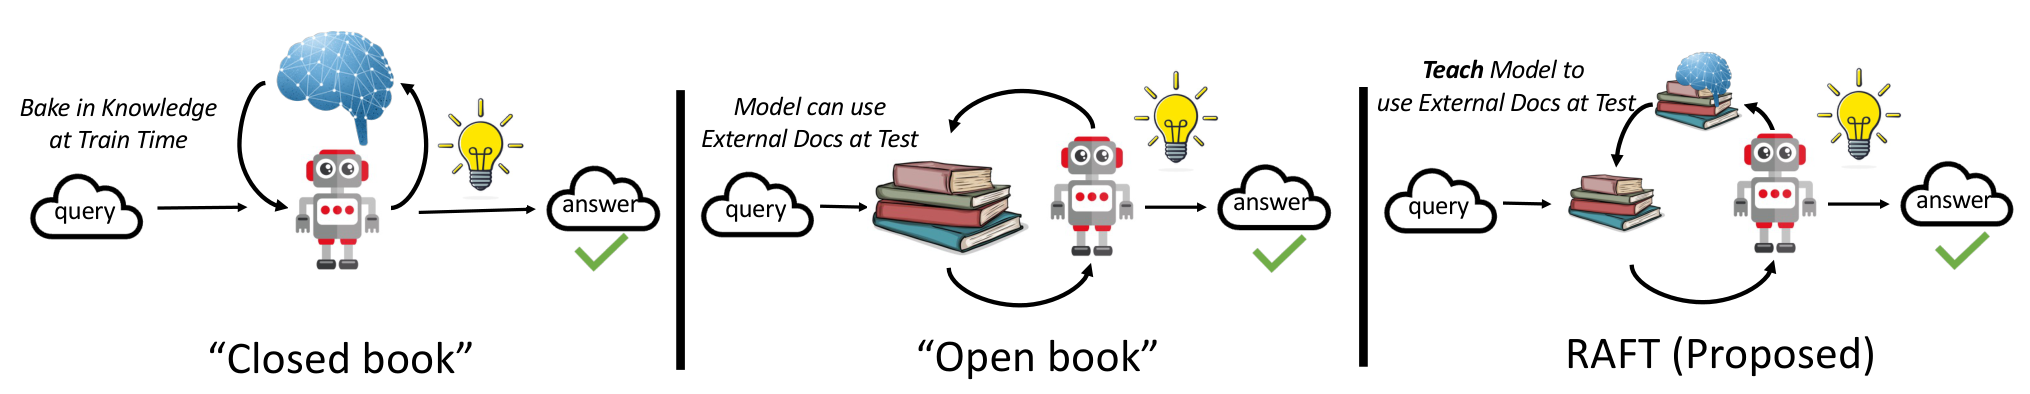

In [83]:
#print(docs)
plt_img_base64(docs[0])

In [86]:
print(chain_multimodal_rag.invoke(query))

RAFT는 "Retrieval-Augmented Fine-Tuning"의 약자로, 언어 모델을 특정 도메인에 맞게 적응시키는 방법입니다. 이 방법은 모델이 테스트 시 외부 문서를 활용할 수 있도록 가르치는 것을 목표로 합니다. 

기존의 "Closed book" 접근 방식은 훈련 시 지식을 내재화하여 테스트 시 외부 정보를 사용하지 않습니다. 반면, "Open book" 접근 방식은 테스트 시 외부 문서를 사용할 수 있도록 합니다. RAFT는 이 두 가지 접근 방식을 결합하여, 모델이 외부 문서를 효과적으로 활용할 수 있도록 훈련합니다.

RAFT는 Chain-of-Thought(사고의 연쇄) 기법을 추가하여 성능을 크게 향상시킬 수 있으며, 다양한 데이터셋에서 그 효과가 입증되었습니다. 예를 들어, Hotpot QA와 HuggingFace 데이터셋에서 각각 9.66%와 14.93%의 성능 향상을 보였습니다.

이러한 특성 덕분에 RAFT는 다양한 문서 수에 대한 일반화 능력이 뛰어나며, 실제 응용 프로그램에서 다양한 시나리오에 대비할 수 있는 강력한 모델로 평가받고 있습니다.
